## Machine Learning Assignment 1
### Question 2b
#### Group 1: Siow Meng Low, Louise Fallon, Nikhita Venkatesan, George Pastakas, Cecilia Nok Sze Cheung, Steven Locorotondo

#### Group Assignment: Predicting Wine Quality with k-Nearest Neighbours

In this assignment we will use the data file [wine_quality-red.csv](http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/) which contains red variants of the Portuguese "Vinho Verde" wine. More information on the dataset can be found [here](http://archive.ics.uci.edu/ml/datasets/Wine+Quality).

##### 1. Loads Data File

First of all, we import the required Python libraries. Then, we set the seed and load the red wines data.

In [1]:
%matplotlib inline

import itertools
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

seedValue = 66
np.random.seed(seedValue)

# Load dataset
red_wine = pd.read_csv('winequality-red.csv', sep = ';')


##### 2. Binary Column - "Good Wine"

Next, we define a boolean-typed column "Good Wine" in the dataframe. A value "True" indicates it's a good wine while value "False" indicates otherwise.

In [2]:
# Construct a new binary column “GoodWine” that indicates whether the wine is good 
# which we define as having a quality of 6 or higher or not
red_wine['GoodWine'] = (red_wine['quality'] >= 6)

# Show the first 5 rows of the redWine dataframe
red_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,GoodWine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,True
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False


##### 3. Split into Training (~50%) and Test (~50%) Sets

We then split the dataset into two sets: training and test set (approximately ~50% of the data each set). All the columns, except 'Quality' and 'GoodWine' columns, are used as predictors. The 'GoodWine' column is used as the outcome variable.

Note that the scikit-learn function 'train_test_split' does the record shuffling before splitting into training and test sets.

In [3]:
# Split dataset randomly into training and test dataset (~50% each) 
train, test = train_test_split(red_wine, test_size = 0.5, random_state = seedValue)

trainX = train.iloc[ : , :-2].as_matrix()
testX = test.iloc[ : , :-2].as_matrix()
trainY = train['GoodWine'].as_matrix()
testY = test['GoodWine'].as_matrix()

##### 4. Z-Score Normalisation

Since the predictors are on different scale, we will need to normalise them before using k-Nearest Neighbours to train them. We first estimate the mean and standard deviation using the training samples and use them to calculate the zScore for both training and test sets.

Two helper functions are defined to facilitate the scaling:  

1. Compute column-wise mean and standard deviations (note that unbiased sample standard deviation is used, i.e. denominator is N - 1)
2. Calculate the normalised z-Score

Note that we use the unbiased sample standard deviation as estimate (i.e. N - 1 as denominator).

In [4]:
def compMeanStd(dataMatrix):
    # Use sample standard deviation (denominator = n - 1)
    return np.mean(dataMatrix, axis = 0), np.std(dataMatrix, axis = 0, ddof = 1)

def zScore(dataMatrix, meanValue, stdValue):
    return ((dataMatrix - meanValue) / stdValue)

meanVal, stdVal = compMeanStd(trainX)
# Scale data using only the estimates from (training + validation) data
trainXscaled = zScore(trainX, meanVal, stdVal)
testXscaled = zScore(testX, meanVal, stdVal)

##### 5&6. k-Nearest Neighbours Training and 5-Fold Cross Validation

In this section, we train the the k-Nearest Neighbours classifier (with different k values) and validate them using 5-fold cross-validation approach.

For Part 5, we train the model using all the training data and record the in-training performance for different K-values (to be used in the plot in later section).

For Part 6, we divide the training data using 5 folds and use 5-fold cross validation approach to obtain the average validation performance (for different values of K). The K-value, which yields the best validation performance (in terms of accuracy), will be selected as the final model.

Note that we use accuracy as the performance measure for comparing models, since the objective of this Machine Learning application is not clearly specified. If detecting true positives were more important (for this application), we could use sensitivity and if true negatives were more important, we could use specificity.

In [5]:
# For the training set, use k-fold cross validation to split into training and validation
kf = KFold(n_splits = 5, random_state = seedValue)

for k in range(1, 502, 5):
    
    # Part 5: Train using all training data and obtain training data performance (used for plot later)
    clf = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
    clf.fit(trainXscaled, trainY) # Fit on training data
    prediction = clf.predict(trainXscaled)
    actual = trainY # Actual outcome values of validation data
    numTP = sum((actual == True) & (prediction == True))
    numTN = sum((actual == False) & (prediction == False))
    trainAcc = (numTP + numTN) / len(actual)
    trainSens = numTP / sum(actual == True)
    trainSpec = numTN / sum(actual == False)
    if k == 1:
        TrainPerfK = [[k, np.mean(trainAcc), np.mean(trainSens), np.mean(trainSpec)]]
    else:
        TrainPerfK = np.append(TrainPerfK, 
                               [[k, np.mean(trainAcc), np.mean(trainSens), np.mean(trainSpec)]], 
                               axis = 0)    
        
    # Part 6: Train and validate by splitting using 5-fold cross validation
    acc = []
    sens = []
    spec = []
    for trainIndex, valIndex in kf.split(trainXscaled):
        clf = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
        clf.fit(trainXscaled[trainIndex], trainY[trainIndex]) # Fit on training data
        # Predict on validation data
        prediction = clf.predict(trainXscaled[valIndex]) # Predict on validation data
        actual = trainY[valIndex] # Actual outcome values of validation data
        numTP = sum((actual == True) & (prediction == True))
        numTN = sum((actual == False) & (prediction == False))
        acc.append((numTP + numTN) / len(actual))
        sens.append(numTP / sum(actual == True))
        spec.append(numTN / sum(actual == False))
    if k == 1:
        CVPerfK = [[k, np.mean(acc), np.mean(sens), np.mean(spec)]]
    else:
        CVPerfK = np.append(CVPerfK, [[k, np.mean(acc), np.mean(sens), np.mean(spec)]], axis = 0)

bestK = CVPerfK[np.argmax(CVPerfK, axis = 0)[1], 0] # Select bestK based on accuracy

##### 7. Generalisation Error and Confusion Matrix

Now we have found the best k value for the k-Nearest Neighbour classifier, we then retrain the classifier using the whole training data and estimate its performance on the test data, in order to obtain the final generalisation error. 

In [6]:
clf = KNeighborsClassifier(n_neighbors = int(bestK), weights = 'uniform')
# Test Phase: Re-train on all training data (all training + validation data used in K-fold)
clf.fit(trainXscaled, trainY)
prediction = clf.predict(testXscaled) # Predict on test data
actual = testY # Actual outcome values of test data
numTP = sum((actual == True) & (prediction == True))
numTN = sum((actual == False) & (prediction == False))
numFN = sum((actual == True) & (prediction == False))
numFP = sum((actual == False) & (prediction == True))
acc = (numTP + numTN) / len(actual)
sens = numTP / sum(actual == True)
spec = numTN / sum(actual == False)
# Confusion matrix - Generalisation Error
testConfMat = pd.DataFrame([[numTP, numFN], [numFP, numTN]], 
                           columns = ['True', 'False'], 
                           index = ['True', 'False'])

The accuracy, sensitivity and specificity (estimated using the predictions on test set) are shown in the table.

In [7]:
pd.DataFrame([[int(bestK), acc, sens, spec]], columns = ['K', 'accuracy', 'sensitivity', 'specificity'])

,K,accuracy,sensitivity,specificity
0,31,0.70875,0.754854,0.659794


To illustrate the whole model selection process, we also plot the classification errors for different values of K, in the below graph.

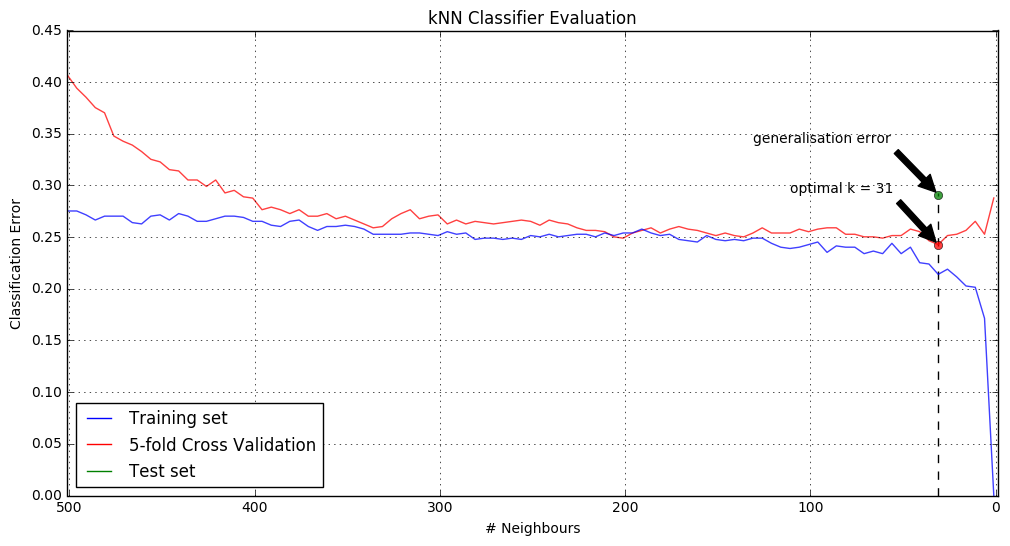

In [8]:
# Plot results
plt.figure(figsize = (12, 6))

plt.axvline(x = bestK, ymin = 0, ymax = 0.65, ls = '--', linewidth =  1, color = 'k')
plt.plot(CVPerfK[ : , 0], 1 - CVPerfK[:, 1], 'r-', color = 'red', alpha = 0.75)
plt.plot(TrainPerfK[ : , 0], 1 - TrainPerfK[:, 1], 'r-', color = 'blue', alpha = 0.75)

validationClassError = 1 - CVPerfK[CVPerfK[ : , 0] == bestK, 1].item()
plt.plot(bestK, validationClassError, 'ro', alpha = 0.75)
plt.annotate('optimal k = ' + str(int(bestK)), xy=(bestK, validationClassError), 
             xytext=(bestK + 80, validationClassError + 0.05), \
             arrowprops = dict(facecolor = 'k', shrink = 0.05))

testClassError = 1 - acc
plt.plot(bestK, testClassError, 'ro', color = 'green', alpha = 0.75)
plt.annotate('generalisation error', xy=(bestK, testClassError), 
             xytext=(bestK + 100, testClassError + 0.05), \
             arrowprops = dict(facecolor = 'k', shrink = 0.05))

plt.xlabel('# Neighbours')
plt.ylabel('Classification Error')
plt.title('kNN Classifier Evaluation')
plt.grid(True)
plt.xlim([-1, 501])
plt.gca().invert_xaxis()

# Create legend
blue_line = mlines.Line2D([], [], color = 'blue', label = 'Training set')
red_line = mlines.Line2D([], [], color = 'red', label = '5-fold Cross Validation')
green_line = mlines.Line2D([], [], color = 'green', label = 'Test set')

plt.legend(handles = [blue_line, red_line, green_line], loc = 3)

plt.show()

The green dot above indicates the generalisation error (measured using estimation misclassification rate (i.e. 1 - accuracy), obtained using test set.

Next, we will plot the confusion matrix of the prediction results using the test set.

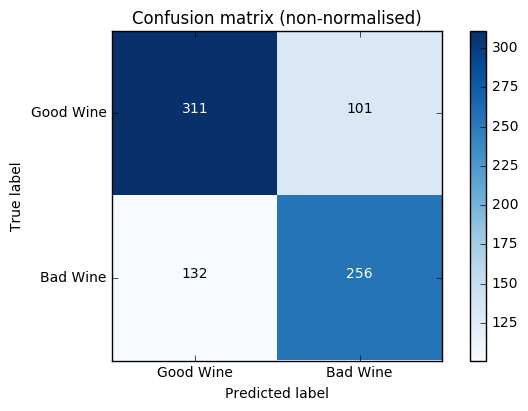

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(prediction, testY, labels = [True, False])

# Specify labels for the two classes
class_names = ['Good Wine', 'Bad Wine']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, \
                      classes = class_names, \
                      title = 'Confusion matrix (non-normalised)')
plt.show()

##### Ending: Train on All Data for Future Use

After we have our estimate of the generalisation error, we can train the classifier using all the data for predictions of future data.

In [10]:
# Finally, train on all data for future use
redWinesX = red_wine.iloc[ : , :-2].as_matrix()
redWinesY = red_wine['GoodWine'].as_matrix()

meanAll, stdAll = compMeanStd(redWinesX)
redWinesXscaled = zScore(redWinesX, meanAll, stdAll) # Scale using estimates from all data

clf.fit(redWinesXscaled, redWinesY) # Fit on all data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=2,
           weights='uniform')

##### How do you judge whether the classifier is well-suited for the data set?

In this Python exercise we have similar observations with the R exercise (Q2a):

###### Selection of K-value for K-Nearest Neighbours

From the earlier kNN classifier evaluation graph, we can observe that a large range of K-values produce similar validation performance. A different seed value (used in shuffling and splitting the train and test data) generally leads to a different optimal K-value, and a similar validation performance variations (with large number of K-values producing similar validation performance).

Hence the selection of K, within this broad range, may not have huge impact on accuracy of prediction for future data points.

###### Comparison to Benchmark Classifier

A naive majority-based classifier can be used as benchmark. This classifier would classify all wines as good wines if the proportion of good wines is higher than the proportion of bad wines within the training set (otherwise, classify all wines as bad wines). The estimated accuracy of this naive predictor is as below:

In [11]:
# Naive Majority-based predictor
if (sum(trainY) / len(trainY) > 0.5): # if 'True' label is more than 50% of the training data
    # Benchmark accuracy of naive predictor which predicts everything as True
    print('Benchmark Accuracy: ', 100 * sum(testY) / len(testY), '%', sep = '')
else:
    # Benchmark accuracy of naive predictor which predicts everything as False
    print('Benchmark Accuracy: ', 100 * (1 - (sum(testY) / len(testY))), '%', sep = '')

Benchmark Accuracy: 51.5%


Our kNN classifier achieves much better accuracy than this benchmark. However, with an accuracy of around 70%, it is still not a highly accurate classifier. 

###### Consideration of Other Performance Measure

In this exercise, we use accuracy as the performance measure. Depending on the application, other performance measures could be used. In the situation where we would like to detect as many true negatives as possible, specificity would be a better performance measure to use. 

The kNN classifier we selected, has an estimated specificity of around 66%. This could be potentially improved if we were to select the model based on specificity performance, during the 5-fold cross validation phase.

###### Non-Parametric Approach of k-NN

K-NN classifier adopts a non-parametric approach and hence the model can not be interpreted. It doesn't provide insights on the learned mechanisms. Consequently, we can't draw statistical inference on how the outcome variable (good or bad wine) depends on the inputs (e.g. sugar contents, acidity). For example, by how much does sugar contents influence the likelihood of a wine being high quality?
